## Import

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import random
import pickle
import cv2
import os

### Define

In [2]:
EPOCHS = 75
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (224, 224, 3)

## Functions

In [3]:
def print_label_details(labels):

    print(len(labels))

    count_h = 0
    count_n = 0
    count_bending = 0
    count_couching = 0
    count_others = 0
    count_standing = 0
    for label in labels:
        if label[0] == 1:
            count_bending += 1
        if label[1] == 1:
            count_couching += 1
        if label[2] == 1:
            count_h += 1
        if label[3] == 1:
            count_n += 1
        if label[4] == 1:
            count_others += 1
        if label[5] == 1:
            count_standing += 1

    print("bending: {}\ncrouching: {}\n_h: {}\n_n: {} \nothers: {}\nstanding: {}".format(count_bending, 
                                                                                         count_couching, 
                                                                                         count_h, 
                                                                                         count_n, 
                                                                                         count_others, 
                                                                                         count_standing))
    

def get_files_path(path, file_extension):
    file_content = []
    for root, dirs, files in os.walk(path):
        for file in files:
            lower_file = file.lower()
            if lower_file.endswith(file_extension):
                file_path = os.path.join(path, file)
                file_content.append(file_path)
        break
    return file_content


def prediction(file_path, model, mlb):
    image = cv2.imread(file_path)

    # pre-process the image for classification
    image = cv2.resize(image, (224, 224))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    # prediction
    proba = model.predict(image)[0]
    idxs = np.argsort(proba)[::-1][:2]
    
    # build the label 
    label = "{}_{}".format(mlb.classes_[idxs[0]], mlb.classes_[idxs[1]])
    
    return label

def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10,10)):

    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

## Testing

In [4]:
# Load images
test_image_paths = sorted(list(paths.list_images('./pose_dataset/test_set')))
random.seed(42)
random.shuffle(test_image_paths)
print(len(test_image_paths))

225


In [5]:
test_data = []
test_labels = []

# loop over the input images
for test_image_path in test_image_paths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(test_image_path)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    test_data.append(image)

    # extract set of class labels from the image path and update the
    # labels list
    l = label = test_image_path.split(os.path.sep)[-2].split("_")
    test_labels.append(l)
    
# scale the raw pixel intensities to the range [0, 1]
test_data = np.array(test_data, dtype="float") / 255.0
test_labels = np.array(test_labels)
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
    len(test_image_paths), test_data.nbytes / (1024 * 1000.0)))

# binarize the labels using scikit-learn's special multi-label
# binarizer implementation
print("[INFO] class labels:")
test_mlb = MultiLabelBinarizer()
test_labels = test_mlb.fit_transform(test_labels)

# loop over each of the possible class labels and show them
for (i, label) in enumerate(test_mlb.classes_):
    print("{}. {}".format(i + 1, label))
    
print_label_details(test_labels)

[INFO] data matrix: 225 images (264.60MB)
[INFO] class labels:
1. bending
2. crouching
3. h
4. n
5. others
6. standing
225
bending: 60
crouching: 45
_h: 111
_n: 114 
others: 60
standing: 60


In [9]:
# construct the image generator
test_generator = ImageDataGenerator().flow(test_data, test_labels, batch_size=BS)
steps_test = test_generator.n / BS

# load model
_model = load_model('pose_multi_labels_mobilenet_v2.h5')
# load labels binary file
_mlb = pickle.loads(open('mlb.pickle', "rb").read())

In [10]:
# evaluate model
print(_model.evaluate_generator(test_generator, steps=steps_test))

[0.7822750180297428, 0.8585185101297167]


In [12]:
test_files = get_files_path('./pose_dataset/test_set/bending_h', 'jpg')
label_results = []
image_tests = []
for f in test_files:
    img = cv2.imread(f)
    cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tests.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    label_results.append(prediction(f, _model, _mlb))

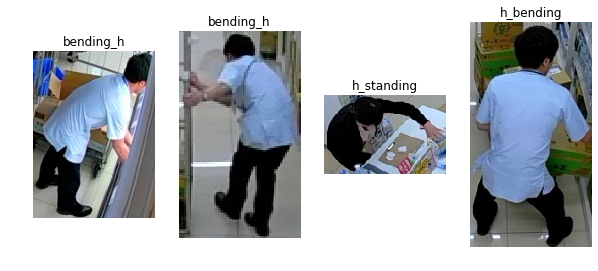

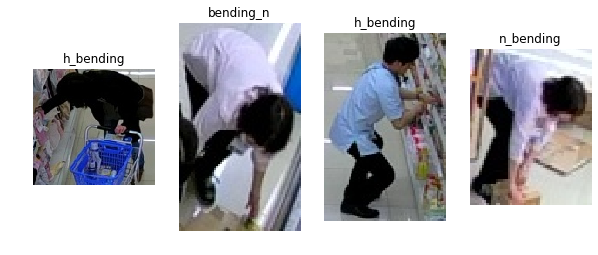

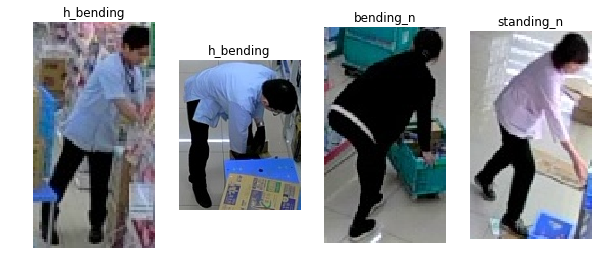

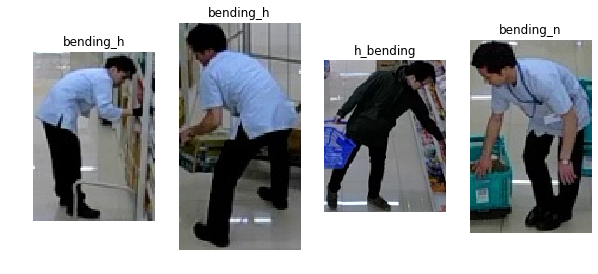

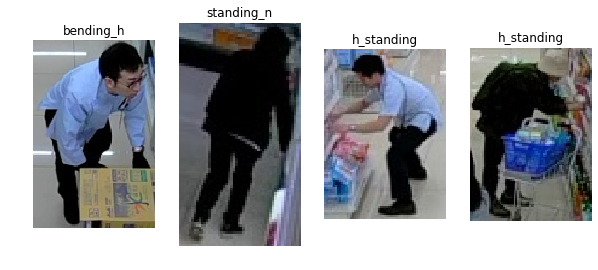

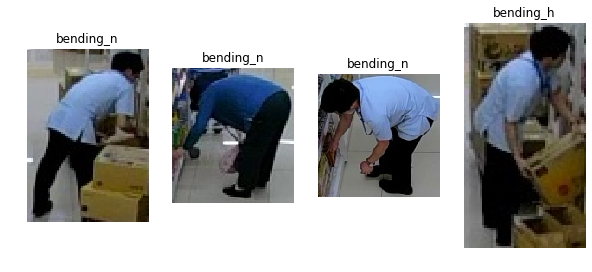

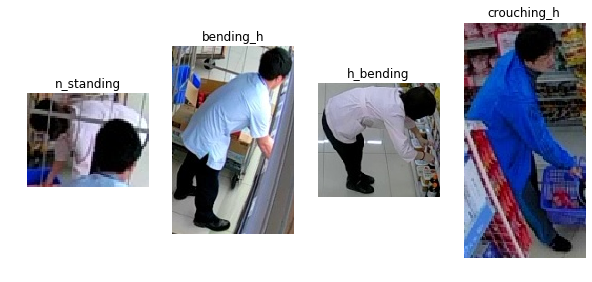

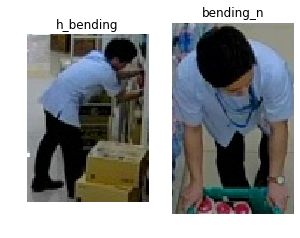

In [13]:
grid_display(image_tests, label_results, 4)